In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import os
import time
from tqdm.autonotebook import tqdm
import sklearn

%matplotlib inline

<b> Prepare the data:</b>

In [2]:
#Prepare the data 
img_augmentation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])       
    ])

In [3]:
# create a class that connects the image ID's with the correct index in the CSV
class LouisianaDataset(Dataset):
    def __init__(self, type):
        if type == 'train':
            self.df = pd.read_csv("train.csv")
            self.image_folder = "train/"
        else:
            self.df = pd.read_csv("test.csv")
            self.image_folder = "test/"
        
        self.imgs = self.df[self.df['Normal']==1]
        self.imgs = self.imgs['Image ID'].values

    def __getitem__(self, idx):
        before_img_path = os.path.join(self.image_folder, self.imgs[idx])
        flood_img_path = glob(self.image_folder+self.imgs[idx].split('.')[0]+'_*')[0]

        before_img = Image.open(before_img_path)
        before_img = img_augmentation(before_img)
        flood_img = Image.open(flood_img_path)
        flood_img = img_augmentation(flood_img)

        label = int(flood_img_path.split('_')[-1].split('.')[0])
        
        return (before_img,flood_img,torch.as_tensor([label], dtype=torch.float))

    def __len__(self):
        return len(self.imgs)

In [4]:
# Load the datasets
train_data = LouisianaDataset('train')
print('No. of training samples: ',len(train_data))
valid_data = LouisianaDataset('valid')
print('No. of validation samples: ',len(valid_data))

No. of training samples:  135
No. of validation samples:  26


In [5]:
num_workers = 0
bs = 8

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=True, num_workers=num_workers)

<b> Model: </b>

In [6]:
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.network1 = models.mobilenet_v2(pretrained=True)
        self.network2 = models.mobilenet_v2(pretrained=True)
        self.distance = torch.nn.PairwiseDistance(keepdim=True)
        self._bn = torch.nn.BatchNorm1d(1)
        self._act = torch.nn.Sigmoid()
        
    def forward(self, input1, input2):
        feats1 = self.network1(input1)
        feats2 = self.network2(input2)
        distance = self.distance(feats1, feats2)
        output = self._bn(distance)
        output = self._act(output)
        return output

In [7]:
%%capture
model = SiameseNetwork()
# model.cuda()


In [9]:
num_epochs = 25
# num_epochs = 25 (for final model, only running 5 for th MVP)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
# Try out using lightening? 
# Wrapper around PyTorch
# I have to write my own training loop for PyTorch- Deep Lizard. 

<b> <font size= 10> Training: </b>

In [10]:
train_losses = []
valid_losses = []

In [11]:
start_ts = time.time()
for epoch in range(num_epochs):
    # ----------------- TRAINING  -------------------- 
    train_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Train_loss: ", total=len(train_loader))
    # set model to training
    model.train()
    
    for i, data in progress:
        img0, img1, label = data
        #img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        # training step for single batch
        model.zero_grad()
        optimizer.zero_grad()
        pred = model(img0,img1)
        loss = criterion(pred,label)
        loss.backward()
        optimizer.step()

        # getting training quality data
        train_loss += loss.item()

        # updating progress bar
        progress.set_description("Train_loss: {:.4f}".format(train_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    # if torch.cuda.is_available():
        # torch.cuda.empty_cache()
    
    train_loss = train_loss/len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, training loss: {train_loss}")

    train_losses.append(train_loss)
    
    # ----------------- VALIDATION -------------------- 
    
    valid_loss = 0.0
    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(valid_loader), desc="Valid_loss: ", total=len(valid_loader))
    # set model to training
    model.eval()
    
    for i, data in progress:
        img0, img1, label = data
        # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        pred = model(img0,img1)
        loss = criterion(pred,label)

        # getting validation quality data
        valid_loss += loss.item()

        # updating progress bar
        progress.set_description("Valid_loss: {:.4f}".format(train_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    # if torch.cuda.is_available():
        # torch.cuda.empty_cache()
    
    valid_loss = valid_loss/len(valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, valid loss: {valid_loss}")

    valid_losses.append(valid_loss)
    
    print('- '*50)

print(f"Training time: {time.time()-start_ts}s")

Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/25, training loss: 0.5899225508465487


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25, valid loss: 0.5177176594734192
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25, training loss: 0.43502990463200736


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25, valid loss: 0.4325774386525154
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25, training loss: 0.4364975340226117


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25, valid loss: 0.4000316970050335
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25, training loss: 0.38433800900683684


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25, valid loss: 0.4772248715162277
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25, training loss: 0.3933437028351952


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25, valid loss: 0.4821022227406502
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25, training loss: 0.37252351992270527


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25, valid loss: 0.41065777838230133
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25, training loss: 0.35612659769899707


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25, valid loss: 0.45000211149454117
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25, training loss: 0.39061995464212756


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25, valid loss: 0.39158425480127335
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25, training loss: 0.3540303935022915


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25, valid loss: 0.43485403060913086
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25, training loss: 0.34048672984628114


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25, valid loss: 0.45892544835805893
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25, training loss: 0.3770445217104519


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25, valid loss: 0.5205132588744164
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25, training loss: 0.34752897655262666


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25, valid loss: 0.45781224966049194
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25, training loss: 0.35959063733325286


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25, valid loss: 0.35860516130924225
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25, training loss: 0.34201278756646547


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25, valid loss: 0.4563092291355133
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25, training loss: 0.3595731644069447


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25, valid loss: 0.5503956153988838
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25, training loss: 0.3446333671317381


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25, valid loss: 0.44138503074645996
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25, training loss: 0.3072216651018928


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25, valid loss: 0.4170992523431778
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25, training loss: 0.3534325361251831


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25, valid loss: 0.41168659180402756
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25, training loss: 0.36528225330745473


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25, valid loss: 0.4767482131719589
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25, training loss: 0.36910275851978974


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25, valid loss: 0.3921602666378021
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25, training loss: 0.31704146546476025


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25, valid loss: 0.42278457432985306
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25, training loss: 0.3226478432907778


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25, valid loss: 0.41372567415237427
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25, training loss: 0.313882473637076


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25, valid loss: 0.4136015698313713
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25, training loss: 0.33283090766738443


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25, valid loss: 0.4826469197869301
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Train_loss:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25, training loss: 0.34758873722132516


Valid_loss:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25, valid loss: 0.45047400891780853
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training time: 4974.849802970886s


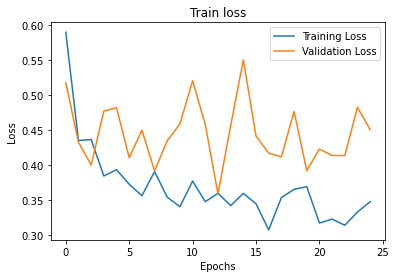

In [13]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")

plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.savefig('traing_progress.png')
plt.show()

<b> INFERENCE: </b>

Inference


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

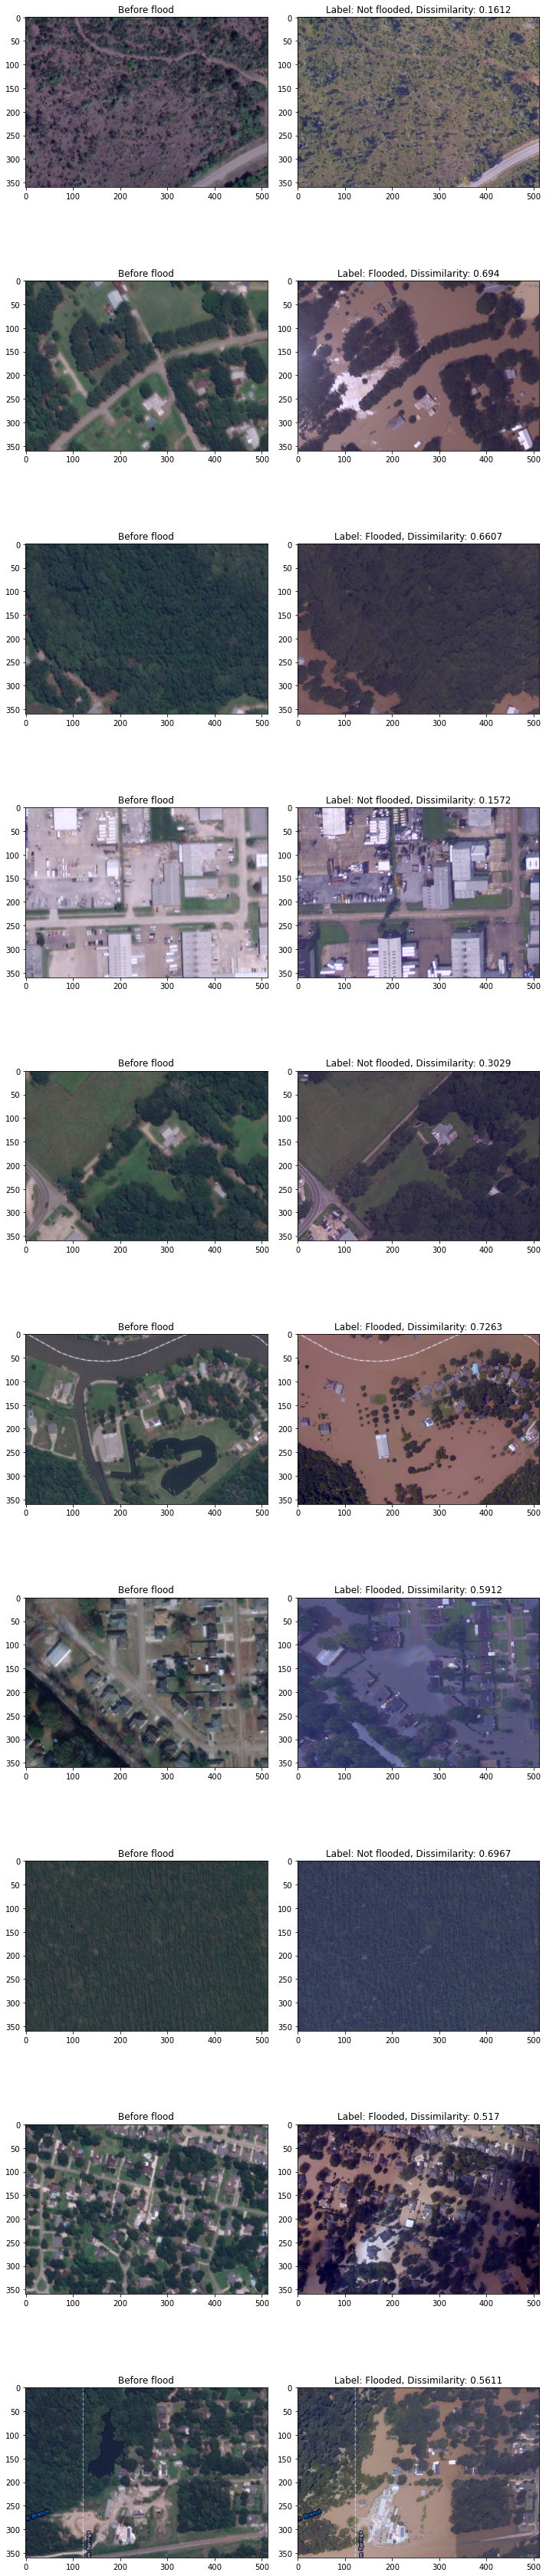

In [15]:
print("Inference")

mean = np.array([0.456, 0.406, 0.485])
std = np.array([0.224, 0.225, 0.229])

model.eval()

columns = 2; rows = 10
fig=plt.figure(figsize=(columns*5, rows*5))
for i in range(0, columns*rows, 2):
    image0, image1, label = valid_data[i]
    img0, img1 = image0[None,:,:,:], image1[None,:,:,:]
    # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    pred = model(img0,img1)
    
    fig.add_subplot(rows,columns,i+1)
    image0 = image0.permute(1, 2, 0).numpy()
    image0 = image0 * std
    image0 = image0 + mean
    plt.imshow(image0)
    plt.title("Before flood")
    plt.tight_layout()
    fig.add_subplot(rows,columns,i+2)
    image1 = image1.permute(1, 2, 0).numpy()
    image1 = image1 * std
    image1 = image1 + mean
    plt.imshow(image1)
    ftitle_true = 'Flooded' if int(label.cpu().detach().numpy())==1 else 'Not flooded'
    plt.title('Label: '+ftitle_true +', Dissimilarity: '+str(round(float(pred.cpu().detach().numpy()), 4)))
    plt.tight_layout()

plt.show()

<b> Summary of Prediction Results: </b>

In [18]:
all_preds = torch.tensor([])
all_targets = torch.tensor([])

for i, data in enumerate(valid_loader):
    model.eval()
    
    img0, img1, label = data
    # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda
    pred = model(img0,img1)
    all_preds = torch.cat((all_preds, pred), dim=0)
    all_targets = torch.cat((all_targets, label), dim=0)
    
all_preds = all_preds.squeeze().cpu().detach().numpy()
all_targets = all_targets.squeeze().cpu().detach().numpy()
torch.cuda.empty_cache()

In [19]:
flood_preds = []
normal_preds = []
for i, label in enumerate(all_targets):
    if label == np.float32(1.0):
        flood_preds.append(float(all_preds[i]))
    else:
        normal_preds.append(float(all_preds[i]))

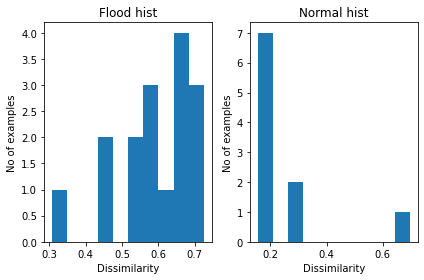

In [20]:
fig = plt.figure(tight_layout=True)
fig.add_subplot(1, 2, 1)
plt.hist(flood_preds)
plt.title('Flood hist')
plt.xlabel("Dissimilarity")
plt.ylabel("No of examples")
fig.add_subplot(1, 2, 2)
plt.hist(normal_preds)
plt.title('Normal hist')
plt.xlabel("Dissimilarity")
plt.ylabel("No of examples")
plt.show()

In [21]:
threshold = np.mean(normal_preds) + np.std(normal_preds)
threshold

0.40239515465480147

In [27]:
all_preds[all_preds > threshold] = 1
all_preds[all_preds != 1] = 0

In [28]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
confusion_matrix(all_preds, all_targets)

Confusion Matrix : 


array([[ 9,  1],
       [ 1, 15]])